In [1]:
%matplotlib inline

import os, sys, glob, shutil
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import argparse
import yaml
import json
import torchaudio
import matplotlib
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
import pyworld as pw
from tqdm.notebook import tqdm

In [2]:
%cd "D:\Schoolwork\TERM 3\WORK\visual_prosody"

D:\Schoolwork\TERM 3\WORK\visual_prosody


In [3]:
train_df = pd.read_csv('./jupyter_walkthrough/side_exp/video_to_prosody_v6_train.csv')

In [4]:
cols = [
    'uid', 'vid', 'embedding_video_start_time',
    'embedding_seq_nohistory_idx', 
    'avg_pitch', 'avg_pitch_delta',
    'avg_energy', 'avg_energy_delta', 
    'pitch_mean', 'pitch_std',
    'energy_mean', 'energy_std']
train_df.iloc[:, :len(cols)].shape

(118201, 12)

In [5]:
train_df.iloc[:, len(cols):].values.shape

(118201, 1536)

In [6]:
train_df.loc

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

In [8]:
class ReversePredictionDataset(Dataset):
    def __init__(self, df_path, target_col):
        self.df = pd.read_csv(df_path)
        assert target_col in ['avg_pitch', 'avg_pitch_delta',
        'avg_energy', 'avg_energy_delta']
        self.target_col = target_col
        cols = [
        'uid', 'vid', 'embedding_video_start_time',
        'embedding_seq_nohistory_idx', 
        'avg_pitch', 'avg_pitch_delta',
        'avg_energy', 'avg_energy_delta', 
        'pitch_mean', 'pitch_std',
        'energy_mean', 'energy_std']
        self.embeddings = torch.FloatTensor(self.df.iloc[:, len(cols):].values)
        self.df = self.df.iloc[:, :len(cols)]
        self.targets = torch.FloatTensor(self.df[self.target_col].values)

    def __len__(self):
        return self.embeddings.shape[0]

    def __getitem__(self, idx):
        target = self.targets[idx]
        features = self.embeddings[idx]

        uid = self.df['uid'].values[idx]
        vid = self.df['vid'].values[idx]
        embedding_video_start_time = self.df['embedding_video_start_time'].values[idx]
        embedding_seq_nohistory_idx = self.df['embedding_seq_nohistory_idx'].values[idx]
        pitch_mean = self.df['pitch_mean'].values[idx]
        pitch_std = self.df['pitch_std'].values[idx]
        energy_mean = self.df['energy_mean'].values[idx]
        energy_std = self.df['energy_std'].values[idx]

        infos = (uid, vid, embedding_video_start_time, embedding_seq_nohistory_idx, pitch_mean, pitch_std, energy_mean, energy_std)        
        return features, target, infos

In [9]:
train_dataset_p = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_train.csv', 
    target_col='avg_pitch'
)

train_dataloader_p = DataLoader(train_dataset_p, batch_size=256, shuffle=True)

val_dataset_p = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_val.csv', 
    target_col='avg_pitch'
)

val_dataloader_p = DataLoader(val_dataset_p, batch_size=64, shuffle=True)

In [10]:
train_dataset_pdelta = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_train.csv', 
    target_col='avg_pitch_delta'
)

train_dataloader_pdelta = DataLoader(train_dataset_pdelta, batch_size=256, shuffle=True)

val_dataset_pdelta = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_val.csv', 
    target_col='avg_pitch_delta'
)

val_dataloader_pdelta = DataLoader(val_dataset_pdelta, batch_size=64, shuffle=True)

In [11]:
train_dataset_e = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_train.csv', 
    target_col='avg_energy'
)

train_dataloader_e = DataLoader(train_dataset_e, batch_size=256, shuffle=True)

val_dataset_e = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_val.csv', 
    target_col='avg_energy'
)

val_dataloader_e = DataLoader(val_dataset_e, batch_size=64, shuffle=True)

In [12]:
train_dataset_edelta = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_train.csv', 
    target_col='avg_energy_delta'
)

train_dataloader_edelta = DataLoader(train_dataset_edelta, batch_size=256, shuffle=True)

val_dataset_edelta = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_val.csv', 
    target_col='avg_energy_delta'
)

val_dataloader_edelta = DataLoader(val_dataset_edelta, batch_size=64, shuffle=True)

In [13]:
import torch.nn as nn
import torch.nn.functional as F


# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(1536, 16)
#         self.fc2 = nn.Linear(16, 16)
#         # self.fc3 = nn.Linear(256, 32)
#         self.fc4 = nn.Linear(16, 1)
#         self.dropout = nn.Dropout(p=0.2)

#     def forward(self, x):
#         x = self.dropout(F.relu(self.fc1(x)))
#         # x = self.dropout(F.relu(self.fc2(x)))
#         # x = self.dropout(F.relu(self.fc3(x)))
#         # x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         # x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x

In [14]:
from torcheval.metrics import MeanSquaredError

In [15]:
def evaluate(model, val_loader, device, naive_rmse=None, model_type=None):
    metric = nn.MSELoss(reduction='none')
    preds_val = []
    targets_val = []
    model.eval()
    model = model.to(device)
    # for idx, data in tqdm(enumerate(val_loader)):
    for idx, data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        X_val, y_val, infos = data
        (uid, vid, embedding_video_start_time, embedding_seq_nohistory_idx, pitch_mean, pitch_std, energy_mean, energy_std) = infos
        
        X_val = X_val.to(device)
        # y_val = y_val.to(device)
        with torch.no_grad():
            pred_val = model(X_val)
        preds_val.append(pred_val)
        targets_val.append(y_val)
    preds_val = torch.cat(preds_val).reshape(-1)
    targets_val = torch.cat(targets_val)
    rmses = torch.sqrt(metric(preds_val.cpu(), targets_val.cpu()))
    # print(mses.shape)
    print(f"val rmse mean: {rmses.mean()}. val rmse std: {rmses.std()}. ")
    if naive_rmse is not None:
        if rmses.mean().item() < naive_rmse:
            torch.save(model.state_dict(), f"./jupyter_walkthrough/side_exp/{model_type}/model_{model_type}_{rmses.mean().item():.6f}.pth")
            print('Model saved.')
    return rmses
         

In [16]:
def naive_evaluate(model, train_loader, val_loader, device):
    metric = nn.MSELoss(reduction='none')
    preds_val = []
    targets_val = []
    model.eval()
    
    # for idx, data in tqdm(enumerate(val_loader)):
    for idx, data in enumerate(val_loader):
        X_val, y_val, infos = data
        X_val = X_val.to(device)
        targets_val.append(y_val)
    # for idx, data in tqdm(enumerate(train_loader)):
    for idx, data in enumerate(train_loader):
        X_train, y_train, infos = data
        preds_val.append(y_train)
        
    preds_val = torch.cat(preds_val).reshape(-1)
    preds_val_mean = preds_val.mean()
    targets_val = torch.cat(targets_val)
    guesses = torch.ones_like(targets_val) * preds_val_mean
    rmses = torch.sqrt(metric(guesses.cpu(), targets_val.cpu()))
    # print(mses.shape)
    print(f"NAIVE => val rmse mean: {rmses.mean()}. val rmse std: {rmses.std()}. ")
    return rmses

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
import random
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## p

In [22]:
# _ = naive_evaluate(model=model, train_loader=train_dataloader_p, val_loader=val_dataloader_p, device=device)

In [120]:
class MLP_p(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1536, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [121]:
seeds = list(range(5))

In [122]:
MODEL_TYPE = 'pitch'
EPOCHS = 20
model = MLP_p()
naive_rmses = naive_evaluate(model=model, train_loader=train_dataloader_p, val_loader=val_dataloader_p, device=device)
naive_rmse_mean = naive_rmses.mean().item()
loss_history = []
for seed in seeds:
    model = MLP_p()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    model = model.to(device)
    criterion = criterion.to(device)

    
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        model.train()
        for idx, data in tqdm(enumerate(train_dataloader_p)):
            # get the inputs; data is a list of [inputs, labels]
            X_train, y_train, infos = data
            (uid, vid, embedding_video_start_time, embedding_seq_nohistory_idx, pitch_mean, pitch_std, energy_mean, energy_std) = infos
            
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            pred_train = model(X_train)
            loss = criterion(pred_train.reshape(-1), y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_history.append(loss.detach().cpu().item())
        
        _ = evaluate(model=model, val_loader=val_dataloader_p, device=device, naive_rmse=naive_rmse_mean, model_type=MODEL_TYPE)
        model.train()

    print('Finished Training')
    print('=== Training rmse ===')
    _ = evaluate(model=model, val_loader=train_dataloader_p, device=device)
    print('=== Val rmse ===')
    _ = evaluate(model=model, val_loader=val_dataloader_p, device=device)
    print('=== ===')

NAIVE => val rmse mean: 0.7474144697189331. val rmse std: 0.632512092590332. 


0it [00:00, ?it/s]

val rmse mean: 0.7318706512451172. val rmse std: 0.6519133448600769. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7311959266662598. val rmse std: 0.6490013599395752. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.729971170425415. val rmse std: 0.6453739404678345. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7291502356529236. val rmse std: 0.6415996551513672. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7283792495727539. val rmse std: 0.6389186382293701. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7286017537117004. val rmse std: 0.6357318758964539. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7287585139274597. val rmse std: 0.6332700848579407. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7293137907981873. val rmse std: 0.6309758424758911. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7305730581283569. val rmse std: 0.6281024813652039. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.731661319732666. val rmse std: 0.625978410243988. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7320862412452698. val rmse std: 0.6245536804199219. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7334391474723816. val rmse std: 0.622604250907898. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7334688901901245. val rmse std: 0.6218924522399902. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7355620861053467. val rmse std: 0.6196659803390503. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7360137701034546. val rmse std: 0.6189877390861511. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7377870678901672. val rmse std: 0.617317259311676. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7388415932655334. val rmse std: 0.6166622638702393. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7399480938911438. val rmse std: 0.6155766844749451. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.740951418876648. val rmse std: 0.6148743629455566. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7405877113342285. val rmse std: 0.6153024435043335. 
Model saved.
Finished Training
=== Training rmse ===
val rmse mean: 0.669644296169281. val rmse std: 0.6131952404975891. 
=== Val rmse ===
val rmse mean: 0.7405877113342285. val rmse std: 0.6153024435043335. 
=== ===


0it [00:00, ?it/s]

val rmse mean: 0.7252276539802551. val rmse std: 0.6648826003074646. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7251836657524109. val rmse std: 0.6595317721366882. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7245295643806458. val rmse std: 0.6544699668884277. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7235122323036194. val rmse std: 0.6503736972808838. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7219126224517822. val rmse std: 0.647197425365448. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.72062087059021. val rmse std: 0.6439616084098816. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7196617722511292. val rmse std: 0.6412556767463684. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7195785641670227. val rmse std: 0.6383422017097473. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7192853689193726. val rmse std: 0.636592447757721. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7188939452171326. val rmse std: 0.6351108551025391. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7190883755683899. val rmse std: 0.6334655284881592. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7192310690879822. val rmse std: 0.6318931579589844. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7200547456741333. val rmse std: 0.6300033926963806. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.720037043094635. val rmse std: 0.629011869430542. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7215543389320374. val rmse std: 0.6271418929100037. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7209637761116028. val rmse std: 0.6272441744804382. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7224673628807068. val rmse std: 0.6255652904510498. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.723228931427002. val rmse std: 0.6247225999832153. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7236013412475586. val rmse std: 0.624291718006134. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.725008487701416. val rmse std: 0.6230201125144958. 
Model saved.
Finished Training
=== Training rmse ===
val rmse mean: 0.6685001850128174. val rmse std: 0.6213894486427307. 
=== Val rmse ===
val rmse mean: 0.7250085473060608. val rmse std: 0.6230201125144958. 
=== ===


0it [00:00, ?it/s]

val rmse mean: 0.747712254524231. val rmse std: 0.6310869455337524. 


0it [00:00, ?it/s]

val rmse mean: 0.7466116547584534. val rmse std: 0.6295320987701416. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7437228560447693. val rmse std: 0.6281276345252991. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7405625581741333. val rmse std: 0.6267885565757751. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7386069297790527. val rmse std: 0.6253370642662048. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7378149032592773. val rmse std: 0.6236087679862976. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7382954955101013. val rmse std: 0.6209600567817688. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7384012341499329. val rmse std: 0.6191352009773254. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7387171387672424. val rmse std: 0.6176059246063232. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7394947409629822. val rmse std: 0.6159790754318237. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.740289568901062. val rmse std: 0.6146208047866821. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.741274356842041. val rmse std: 0.6132621169090271. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7414597272872925. val rmse std: 0.6127004623413086. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7439764142036438. val rmse std: 0.6105201244354248. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7449237108230591. val rmse std: 0.6097583174705505. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.745697557926178. val rmse std: 0.6092140078544617. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7465459704399109. val rmse std: 0.6088322401046753. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7463270425796509. val rmse std: 0.6091208457946777. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7490369081497192. val rmse std: 0.6073753237724304. 


0it [00:00, ?it/s]

val rmse mean: 0.7503219842910767. val rmse std: 0.6069372296333313. 
Finished Training
=== Training rmse ===
val rmse mean: 0.6662001013755798. val rmse std: 0.6100900173187256. 
=== Val rmse ===
val rmse mean: 0.7503219842910767. val rmse std: 0.6069372296333313. 
=== ===


0it [00:00, ?it/s]

val rmse mean: 0.723244309425354. val rmse std: 0.6661523580551147. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7239248752593994. val rmse std: 0.6523876190185547. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7240241765975952. val rmse std: 0.6451795697212219. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7251771688461304. val rmse std: 0.6395823955535889. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7267090678215027. val rmse std: 0.6351509094238281. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7284312844276428. val rmse std: 0.631682813167572. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7297781109809875. val rmse std: 0.6290244460105896. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7312278151512146. val rmse std: 0.6266670823097229. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7327743768692017. val rmse std: 0.6246735453605652. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7344887852668762. val rmse std: 0.622744619846344. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7377342581748962. val rmse std: 0.6197381019592285. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7387055158615112. val rmse std: 0.6190845370292664. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7410793304443359. val rmse std: 0.6172196865081787. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7404012680053711. val rmse std: 0.6182118654251099. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7424513101577759. val rmse std: 0.6169456243515015. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7467029094696045. val rmse std: 0.6138296127319336. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7448596954345703. val rmse std: 0.6158208847045898. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7458858489990234. val rmse std: 0.6149146556854248. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7461308836936951. val rmse std: 0.6150740385055542. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7462756037712097. val rmse std: 0.6153323650360107. 
Model saved.
Finished Training
=== Training rmse ===
val rmse mean: 0.6627168655395508. val rmse std: 0.607662558555603. 
=== Val rmse ===
val rmse mean: 0.7462756037712097. val rmse std: 0.6153323650360107. 
=== ===


0it [00:00, ?it/s]

val rmse mean: 0.7198954224586487. val rmse std: 0.6881493330001831. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7210434675216675. val rmse std: 0.6715586185455322. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7218499779701233. val rmse std: 0.6611946821212769. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7222639918327332. val rmse std: 0.6532341241836548. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.723353385925293. val rmse std: 0.6475834250450134. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7248149514198303. val rmse std: 0.6426413059234619. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7258636355400085. val rmse std: 0.6396321058273315. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7280685305595398. val rmse std: 0.6358889937400818. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7315663695335388. val rmse std: 0.6307880878448486. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7336146235466003. val rmse std: 0.6284869313240051. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7355660200119019. val rmse std: 0.6264134049415588. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.737946629524231. val rmse std: 0.6242584586143494. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7399126291275024. val rmse std: 0.6231322884559631. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7426910400390625. val rmse std: 0.6210302114486694. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7435616254806519. val rmse std: 0.6208876967430115. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7468724846839905. val rmse std: 0.6188579797744751. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7457488179206848. val rmse std: 0.6201782822608948. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.7474445104598999. val rmse std: 0.6194368600845337. 


0it [00:00, ?it/s]

val rmse mean: 0.7490410208702087. val rmse std: 0.6188132166862488. 


0it [00:00, ?it/s]

val rmse mean: 0.7494131922721863. val rmse std: 0.6191360354423523. 
Finished Training
=== Training rmse ===
val rmse mean: 0.6643788814544678. val rmse std: 0.6116300225257874. 
=== Val rmse ===
val rmse mean: 0.7494131922721863. val rmse std: 0.6191360354423523. 
=== ===


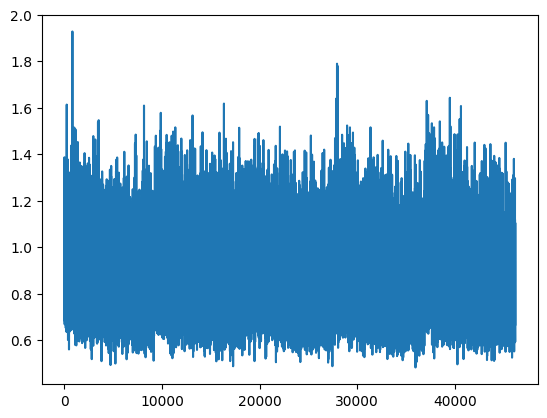

In [123]:
plt.plot(loss_history)

In [124]:
model_paths = glob.glob("./jupyter_walkthrough/side_exp/pitch/*.pth")
model_list = []
for model_path in model_paths:
    # Define your model here, e.g., model = YourModelClass()
    model = MLP_p()
    model.load_state_dict(torch.load(model_path))
    model_list.append(model)
num_models = len(model_list)
print(f"Averaging {num_models} models.")
averaged_state_dict = None

for model in model_list:
    if averaged_state_dict is None:
        averaged_state_dict = model.state_dict()
    else:
        for key, value in model.state_dict().items():
            averaged_state_dict[key] += value
for key in averaged_state_dict.keys():
    averaged_state_dict[key] /= num_models

averaged_model = MLP_p()
averaged_model.load_state_dict(averaged_state_dict)

Averaging 94 models.


<All keys matched successfully>

In [125]:
_ = evaluate(model=averaged_model, val_loader=val_dataloader_p, device=device, naive_rmse=naive_rmse_mean, model_type=MODEL_TYPE)

val rmse mean: 0.726542592048645. val rmse std: 0.6635804176330566. 
Model saved.


## pdelta

In [22]:
# _ = naive_evaluate(model=model, train_loader=train_dataloader_p, val_loader=val_dataloader_p, device=device)

In [98]:
class MLP_pdelta(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1536, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [102]:
seeds = list(range(28,29))

In [104]:
MODEL_TYPE = 'pitch_delta'
EPOCHS = 50
model = MLP_pdelta()
naive_rmses = naive_evaluate(model=model, train_loader=train_dataloader_pdelta, val_loader=val_dataloader_pdelta, device=device)
naive_rmse_mean = naive_rmses.mean().item()
loss_history = []
for seed in seeds:
    model = MLP_pdelta()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    model = model.to(device)
    criterion = criterion.to(device)

    
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        model.train()
        for idx, data in tqdm(enumerate(train_dataloader_pdelta)):
            # get the inputs; data is a list of [inputs, labels]
            X_train, y_train, infos = data
            (uid, vid, embedding_video_start_time, embedding_seq_nohistory_idx, pitch_mean, pitch_std, energy_mean, energy_std) = infos
            
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            pred_train = model(X_train)
            loss = criterion(pred_train.reshape(-1), y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_history.append(loss.detach().cpu().item())
        
        _ = evaluate(model=model, val_loader=val_dataloader_pdelta, device=device, naive_rmse=naive_rmse_mean, model_type=MODEL_TYPE)
        model.train()
    
    
    print('Finished Training')
    print('=== Training rmse ===')
    _ = evaluate(model=model, val_loader=train_dataloader_pdelta, device=device)
    print('=== Val rmse ===')
    _ = evaluate(model=model, val_loader=val_dataloader_pdelta, device=device)
    print('=== ===')

NAIVE => val rmse mean: 0.008535780012607574. val rmse std: 0.014508480206131935. 


0it [00:00, ?it/s]

val rmse mean: 0.053248655050992966. val rmse std: 0.01862853392958641. 


0it [00:00, ?it/s]

val rmse mean: 0.03446868434548378. val rmse std: 0.018479162827134132. 


0it [00:00, ?it/s]

val rmse mean: 0.026576030999422073. val rmse std: 0.01746518164873123. 


0it [00:00, ?it/s]

val rmse mean: 0.021758630871772766. val rmse std: 0.016650184988975525. 


0it [00:00, ?it/s]

val rmse mean: 0.01778220944106579. val rmse std: 0.01604347676038742. 


0it [00:00, ?it/s]

val rmse mean: 0.01511311624199152. val rmse std: 0.015518717467784882. 


0it [00:00, ?it/s]

val rmse mean: 0.01322112511843443. val rmse std: 0.015136494301259518. 


0it [00:00, ?it/s]

val rmse mean: 0.01181953027844429. val rmse std: 0.014849426224827766. 


0it [00:00, ?it/s]

val rmse mean: 0.010817158035933971. val rmse std: 0.014653841033577919. 


0it [00:00, ?it/s]

val rmse mean: 0.010099846869707108. val rmse std: 0.014518245123326778. 


0it [00:00, ?it/s]

val rmse mean: 0.009736740030348301. val rmse std: 0.01443932019174099. 


0it [00:00, ?it/s]

val rmse mean: 0.009483902715146542. val rmse std: 0.014395052567124367. 


0it [00:00, ?it/s]

val rmse mean: 0.00931656826287508. val rmse std: 0.014373849146068096. 


0it [00:00, ?it/s]

val rmse mean: 0.0091790072619915. val rmse std: 0.014349356293678284. 


0it [00:00, ?it/s]

val rmse mean: 0.009127233177423477. val rmse std: 0.014329020865261555. 


0it [00:00, ?it/s]

val rmse mean: 0.009155458770692348. val rmse std: 0.014308045618236065. 


0it [00:00, ?it/s]

val rmse mean: 0.0091425571590662. val rmse std: 0.014312978833913803. 


0it [00:00, ?it/s]

val rmse mean: 0.009153601713478565. val rmse std: 0.014315394684672356. 


0it [00:00, ?it/s]

val rmse mean: 0.009240361861884594. val rmse std: 0.014291337691247463. 


0it [00:00, ?it/s]

val rmse mean: 0.009268047288060188. val rmse std: 0.014279736205935478. 


0it [00:00, ?it/s]

val rmse mean: 0.009441403672099113. val rmse std: 0.014238881878554821. 


0it [00:00, ?it/s]

val rmse mean: 0.009517624042928219. val rmse std: 0.01421527098864317. 


0it [00:00, ?it/s]

val rmse mean: 0.00960766151547432. val rmse std: 0.014197386801242828. 


0it [00:00, ?it/s]

val rmse mean: 0.009561855345964432. val rmse std: 0.01419763918966055. 


0it [00:00, ?it/s]

val rmse mean: 0.0093982620164752. val rmse std: 0.014225848019123077. 


0it [00:00, ?it/s]

val rmse mean: 0.00921424850821495. val rmse std: 0.014258680865168571. 


0it [00:00, ?it/s]

val rmse mean: 0.009106021374464035. val rmse std: 0.014284132048487663. 


0it [00:00, ?it/s]

val rmse mean: 0.008928085677325726. val rmse std: 0.014340038411319256. 


0it [00:00, ?it/s]

val rmse mean: 0.008798114955425262. val rmse std: 0.014386742375791073. 


0it [00:00, ?it/s]

val rmse mean: 0.008723321370780468. val rmse std: 0.014425215311348438. 


0it [00:00, ?it/s]

val rmse mean: 0.008670124225318432. val rmse std: 0.014455046504735947. 


0it [00:00, ?it/s]

val rmse mean: 0.008647467009723186. val rmse std: 0.014467785134911537. 


0it [00:00, ?it/s]

val rmse mean: 0.008633219636976719. val rmse std: 0.014482025057077408. 


0it [00:00, ?it/s]

val rmse mean: 0.008614783175289631. val rmse std: 0.014498405158519745. 


0it [00:00, ?it/s]

val rmse mean: 0.008605952374637127. val rmse std: 0.014498847536742687. 


0it [00:00, ?it/s]

val rmse mean: 0.008568880148231983. val rmse std: 0.014533914625644684. 


0it [00:00, ?it/s]

val rmse mean: 0.008558662608265877. val rmse std: 0.014539981260895729. 


0it [00:00, ?it/s]

val rmse mean: 0.008538375608623028. val rmse std: 0.014561127871274948. 


0it [00:00, ?it/s]

val rmse mean: 0.008535762317478657. val rmse std: 0.014564698562026024. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.008531698025763035. val rmse std: 0.01455222349613905. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.00852867029607296. val rmse std: 0.014547344297170639. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.008527911268174648. val rmse std: 0.014541564509272575. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.00852096639573574. val rmse std: 0.014547079801559448. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.008515718393027782. val rmse std: 0.014554991386830807. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.008515074849128723. val rmse std: 0.01455232035368681. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.008515872992575169. val rmse std: 0.014547617174685001. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.008512119762599468. val rmse std: 0.014551674947142601. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.008519752882421017. val rmse std: 0.01453530602157116. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.00852025393396616. val rmse std: 0.014532726258039474. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.008517736569046974. val rmse std: 0.014535892754793167. 
Model saved.
Finished Training
=== Training rmse ===
val rmse mean: 0.0077027748338878155. val rmse std: 0.013786581344902515. 
=== Val rmse ===
val rmse mean: 0.008517737500369549. val rmse std: 0.014535892754793167. 
=== ===


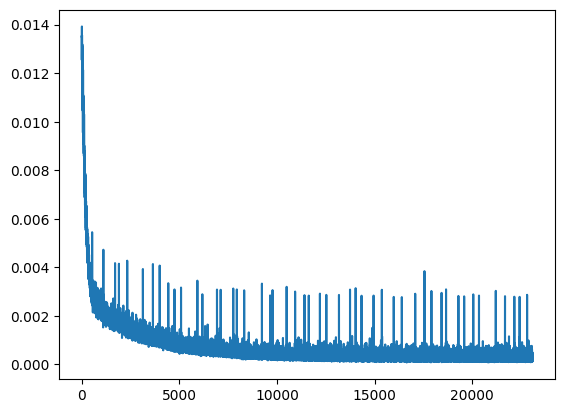

In [105]:
plt.plot(loss_history)

In [107]:
model_paths = glob.glob("./jupyter_walkthrough/side_exp/pitch_delta/*.pth")
model_list = []
for model_path in model_paths:
    # Define your model here, e.g., model = YourModelClass()
    model = MLP_pdelta()
    model.load_state_dict(torch.load(model_path))
    model_list.append(model)
num_models = len(model_list)
print(f"Averaging {num_models} models.")
averaged_state_dict = None

for model in model_list:
    if averaged_state_dict is None:
        averaged_state_dict = model.state_dict()
    else:
        for key, value in model.state_dict().items():
            averaged_state_dict[key] += value
for key in averaged_state_dict.keys():
    averaged_state_dict[key] /= num_models

averaged_model = MLP_pdelta()
averaged_model.load_state_dict(averaged_state_dict)

Averaging 10 models.


<All keys matched successfully>

In [108]:
_ = evaluate(model=averaged_model, val_loader=val_dataloader_pdelta, device=device, naive_rmse=naive_rmse_mean, model_type=MODEL_TYPE)

val rmse mean: 0.008517920039594173. val rmse std: 0.014549287967383862. 
Model saved.


## e

In [81]:
# _ = naive_evaluate(model=model, train_loader=train_dataloader_p, val_loader=val_dataloader_p, device=device)

In [109]:
class MLP_e(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1536, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        # x = self.dropout(F.relu(self.fc3(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [110]:
seeds = list(range(2))

In [111]:
MODEL_TYPE = 'energy'
EPOCHS = 50
model = MLP_e()
naive_rmses = naive_evaluate(model=model, train_loader=train_dataloader_e, val_loader=val_dataloader_e, device=device)
naive_rmse_mean = naive_rmses.mean().item()
loss_history = []
for seed in seeds:
    model = MLP_e()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    model = model.to(device)
    criterion = criterion.to(device)

    
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        model.train()
        for idx, data in tqdm(enumerate(train_dataloader_e)):
            # get the inputs; data is a list of [inputs, labels]
            X_train, y_train, infos = data
            (uid, vid, embedding_video_start_time, embedding_seq_nohistory_idx, pitch_mean, pitch_std, energy_mean, energy_std) = infos
            
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            pred_train = model(X_train)
            loss = criterion(pred_train.reshape(-1), y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_history.append(loss.detach().cpu().item())
        
        _ = evaluate(model=model, val_loader=val_dataloader_e, device=device, naive_rmse=naive_rmse_mean, model_type=MODEL_TYPE)
        model.train()

    print('Finished Training')
    print('=== Training rmse ===')
    _ = evaluate(model=model, val_loader=train_dataloader_e, device=device)
    print('=== Val rmse ===')
    _ = evaluate(model=model, val_loader=val_dataloader_e, device=device)
    print('=== ===')

NAIVE => val rmse mean: 0.5291358232498169. val rmse std: 0.3805970251560211. 


0it [00:00, ?it/s]

val rmse mean: 0.5194976925849915. val rmse std: 0.3945014774799347. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.5201336145401001. val rmse std: 0.3920230269432068. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.5206642150878906. val rmse std: 0.390571653842926. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.521408200263977. val rmse std: 0.3891133964061737. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.5226356983184814. val rmse std: 0.38752928376197815. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.5240622162818909. val rmse std: 0.3864971101284027. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.5255010724067688. val rmse std: 0.38596245646476746. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.5268648862838745. val rmse std: 0.38569343090057373. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.5286331176757812. val rmse std: 0.3854512572288513. 
Model saved.


0it [00:00, ?it/s]

val rmse mean: 0.5297707915306091. val rmse std: 0.3857104778289795. 


0it [00:00, ?it/s]

val rmse mean: 0.5315256118774414. val rmse std: 0.38566625118255615. 


0it [00:00, ?it/s]

val rmse mean: 0.5331465005874634. val rmse std: 0.3857944905757904. 


0it [00:00, ?it/s]

val rmse mean: 0.5344161987304688. val rmse std: 0.3862289488315582. 


0it [00:00, ?it/s]

val rmse mean: 0.536135733127594. val rmse std: 0.3864206075668335. 


0it [00:00, ?it/s]

val rmse mean: 0.5376089811325073. val rmse std: 0.38678643107414246. 


0it [00:00, ?it/s]

val rmse mean: 0.5392725467681885. val rmse std: 0.38719645142555237. 


0it [00:00, ?it/s]

val rmse mean: 0.5410584211349487. val rmse std: 0.3876977562904358. 


0it [00:00, ?it/s]

val rmse mean: 0.5424869656562805. val rmse std: 0.3880341351032257. 


0it [00:00, ?it/s]

val rmse mean: 0.5435993671417236. val rmse std: 0.38868895173072815. 


0it [00:00, ?it/s]

val rmse mean: 0.5451869368553162. val rmse std: 0.3891323208808899. 


0it [00:00, ?it/s]

val rmse mean: 0.5460221171379089. val rmse std: 0.38952121138572693. 


0it [00:00, ?it/s]

val rmse mean: 0.5478612184524536. val rmse std: 0.39014866948127747. 


0it [00:00, ?it/s]

val rmse mean: 0.5488604307174683. val rmse std: 0.3908068537712097. 


0it [00:00, ?it/s]

val rmse mean: 0.5497373342514038. val rmse std: 0.3911246359348297. 


0it [00:00, ?it/s]

val rmse mean: 0.5500270128250122. val rmse std: 0.3914053738117218. 


0it [00:00, ?it/s]

val rmse mean: 0.5510737299919128. val rmse std: 0.3919285535812378. 


0it [00:00, ?it/s]

val rmse mean: 0.5516652464866638. val rmse std: 0.39227426052093506. 


0it [00:00, ?it/s]

val rmse mean: 0.55307537317276. val rmse std: 0.3925805389881134. 


0it [00:00, ?it/s]

val rmse mean: 0.5530973076820374. val rmse std: 0.3925904333591461. 


0it [00:00, ?it/s]

val rmse mean: 0.5527597665786743. val rmse std: 0.3926008641719818. 


0it [00:00, ?it/s]

val rmse mean: 0.552855908870697. val rmse std: 0.3929540514945984. 


0it [00:00, ?it/s]

val rmse mean: 0.5538576245307922. val rmse std: 0.39319342374801636. 


0it [00:00, ?it/s]

val rmse mean: 0.5543299317359924. val rmse std: 0.3935126066207886. 


0it [00:00, ?it/s]

val rmse mean: 0.5548483729362488. val rmse std: 0.3937431573867798. 


0it [00:00, ?it/s]

val rmse mean: 0.554195761680603. val rmse std: 0.3936186730861664. 


0it [00:00, ?it/s]

val rmse mean: 0.5551567673683167. val rmse std: 0.3937543034553528. 


0it [00:00, ?it/s]

val rmse mean: 0.5550714731216431. val rmse std: 0.39374226331710815. 


0it [00:00, ?it/s]

val rmse mean: 0.5554090738296509. val rmse std: 0.39403608441352844. 


0it [00:00, ?it/s]

val rmse mean: 0.5553905963897705. val rmse std: 0.39408090710639954. 


0it [00:00, ?it/s]

val rmse mean: 0.5565324425697327. val rmse std: 0.3945046067237854. 


0it [00:00, ?it/s]

val rmse mean: 0.5564165711402893. val rmse std: 0.39445874094963074. 


0it [00:00, ?it/s]

val rmse mean: 0.5553655028343201. val rmse std: 0.39386606216430664. 


0it [00:00, ?it/s]

val rmse mean: 0.5558800101280212. val rmse std: 0.39437440037727356. 


0it [00:00, ?it/s]

val rmse mean: 0.5565569400787354. val rmse std: 0.394449383020401. 


0it [00:00, ?it/s]

val rmse mean: 0.5561264157295227. val rmse std: 0.39437857270240784. 


0it [00:00, ?it/s]

val rmse mean: 0.5565335750579834. val rmse std: 0.39462515711784363. 


0it [00:00, ?it/s]

val rmse mean: 0.5566548705101013. val rmse std: 0.3945847749710083. 


0it [00:00, ?it/s]

val rmse mean: 0.5567983388900757. val rmse std: 0.3947944939136505. 


0it [00:00, ?it/s]

val rmse mean: 0.5556108355522156. val rmse std: 0.3944973945617676. 


0it [00:00, ?it/s]

val rmse mean: 0.5560706257820129. val rmse std: 0.39457759261131287. 
Finished Training
=== Training rmse ===
val rmse mean: 0.5042353868484497. val rmse std: 0.40959906578063965. 
=== Val rmse ===
val rmse mean: 0.5560706257820129. val rmse std: 0.39457759261131287. 
=== ===


In [116]:
# plt.plot(loss_history)

In [117]:
model_paths = glob.glob("./jupyter_walkthrough/side_exp/energy/*.pth")
model_list = []
for model_path in model_paths:
    # Define your model here, e.g., model = YourModelClass()
    model = MLP_e()
    model.load_state_dict(torch.load(model_path))
    model_list.append(model)
num_models = len(model_list)
print(f"Averaging {num_models} models.")
averaged_state_dict = None

for model in model_list:
    if averaged_state_dict is None:
        averaged_state_dict = model.state_dict()
    else:
        for key, value in model.state_dict().items():
            averaged_state_dict[key] += value
for key in averaged_state_dict.keys():
    averaged_state_dict[key] /= num_models

averaged_model = MLP_e()
averaged_model.load_state_dict(averaged_state_dict)

Averaging 9 models.


<All keys matched successfully>

In [119]:
_ = evaluate(model=averaged_model, val_loader=val_dataloader_e, device=device, naive_rmse=0.52913582324, model_type=MODEL_TYPE)

val rmse mean: 0.5218973159790039. val rmse std: 0.38842830061912537. 
Model saved.


## edelta

In [81]:
# _ = naive_evaluate(model=model, train_loader=train_dataloader_p, val_loader=val_dataloader_p, device=device)

In [112]:
class MLP_edelta(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1536, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        # x = self.dropout(F.relu(self.fc3(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [113]:
seeds = list(range(1))

In [114]:
MODEL_TYPE = 'energy_delta'
EPOCHS = 50
model = MLP_edelta()
naive_rmses = naive_evaluate(model=model, train_loader=train_dataloader_edelta, val_loader=val_dataloader_edelta, device=device)
naive_rmse_mean = naive_rmses.mean().item()
loss_history = []
for seed in seeds:
    model = MLP_edelta()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    model = model.to(device)
    criterion = criterion.to(device)

    
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        model.train()
        for idx, data in tqdm(enumerate(train_dataloader_edelta)):
            # get the inputs; data is a list of [inputs, labels]
            X_train, y_train, infos = data
            (uid, vid, embedding_video_start_time, embedding_seq_nohistory_idx, pitch_mean, pitch_std, energy_mean, energy_std) = infos
            
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            pred_train = model(X_train)
            loss = criterion(pred_train.reshape(-1), y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_history.append(loss.detach().cpu().item())
        
        _ = evaluate(model=model, val_loader=val_dataloader_edelta, device=device, naive_rmse=naive_rmse_mean, model_type=MODEL_TYPE)
        model.train()

    print('Finished Training')
    print('=== Training rmse ===')
    _ = evaluate(model=model, val_loader=train_dataloader_edelta, device=device)
    print('=== Val rmse ===')
    _ = evaluate(model=model, val_loader=val_dataloader_edelta, device=device)
    print('=== ===')

NAIVE => val rmse mean: 0.015284821391105652. val rmse std: 0.02901187725365162. 


0it [00:00, ?it/s]

val rmse mean: 0.07411215454339981. val rmse std: 0.03445497900247574. 


0it [00:00, ?it/s]

val rmse mean: 0.05652708560228348. val rmse std: 0.033315543085336685. 


0it [00:00, ?it/s]

val rmse mean: 0.04781187325716019. val rmse std: 0.031966354697942734. 


0it [00:00, ?it/s]

val rmse mean: 0.041166406124830246. val rmse std: 0.031073395162820816. 


0it [00:00, ?it/s]

val rmse mean: 0.036551784723997116. val rmse std: 0.030343392863869667. 


0it [00:00, ?it/s]

val rmse mean: 0.032944269478321075. val rmse std: 0.0298596378415823. 


0it [00:00, ?it/s]

val rmse mean: 0.03006250411272049. val rmse std: 0.029484450817108154. 


0it [00:00, ?it/s]

val rmse mean: 0.027610821649432182. val rmse std: 0.029171593487262726. 


0it [00:00, ?it/s]

val rmse mean: 0.02546079084277153. val rmse std: 0.028973987326025963. 


0it [00:00, ?it/s]

val rmse mean: 0.02451458014547825. val rmse std: 0.028670310974121094. 


0it [00:00, ?it/s]

val rmse mean: 0.0228787399828434. val rmse std: 0.0286130141466856. 


0it [00:00, ?it/s]

val rmse mean: 0.021344326436519623. val rmse std: 0.02855297178030014. 


0it [00:00, ?it/s]

val rmse mean: 0.020925424993038177. val rmse std: 0.028384774923324585. 


0it [00:00, ?it/s]

val rmse mean: 0.019923752173781395. val rmse std: 0.028390472754836082. 


0it [00:00, ?it/s]

val rmse mean: 0.019537070766091347. val rmse std: 0.02831622213125229. 


0it [00:00, ?it/s]

val rmse mean: 0.019010189920663834. val rmse std: 0.028307607397437096. 


0it [00:00, ?it/s]

val rmse mean: 0.018238628283143044. val rmse std: 0.02839834615588188. 


0it [00:00, ?it/s]

val rmse mean: 0.01787436567246914. val rmse std: 0.02840328775346279. 


0it [00:00, ?it/s]

val rmse mean: 0.017778649926185608. val rmse std: 0.028340188786387444. 


0it [00:00, ?it/s]

val rmse mean: 0.01700524054467678. val rmse std: 0.028555093333125114. 


0it [00:00, ?it/s]

val rmse mean: 0.01704978197813034. val rmse std: 0.028477678075432777. 


0it [00:00, ?it/s]

val rmse mean: 0.016768991947174072. val rmse std: 0.0285412035882473. 


0it [00:00, ?it/s]

val rmse mean: 0.016415182501077652. val rmse std: 0.028678134083747864. 


0it [00:00, ?it/s]

val rmse mean: 0.016339747235178947. val rmse std: 0.028673114255070686. 


0it [00:00, ?it/s]

val rmse mean: 0.016282320022583008. val rmse std: 0.028675492852926254. 


0it [00:00, ?it/s]

val rmse mean: 0.01614159531891346. val rmse std: 0.028739294037222862. 


0it [00:00, ?it/s]

val rmse mean: 0.016166573390364647. val rmse std: 0.028683900833129883. 


0it [00:00, ?it/s]

val rmse mean: 0.016053268685936928. val rmse std: 0.028738094493746758. 


0it [00:00, ?it/s]

val rmse mean: 0.015967875719070435. val rmse std: 0.028797972947359085. 


0it [00:00, ?it/s]

val rmse mean: 0.01589750498533249. val rmse std: 0.0288296639919281. 


0it [00:00, ?it/s]

val rmse mean: 0.015881024301052094. val rmse std: 0.028868013992905617. 


0it [00:00, ?it/s]

val rmse mean: 0.015829438343644142. val rmse std: 0.028858108446002007. 


0it [00:00, ?it/s]

val rmse mean: 0.015816019847989082. val rmse std: 0.028822392225265503. 


0it [00:00, ?it/s]

val rmse mean: 0.01577986404299736. val rmse std: 0.028836630284786224. 


0it [00:00, ?it/s]

val rmse mean: 0.015733866021037102. val rmse std: 0.02885725349187851. 


0it [00:00, ?it/s]

val rmse mean: 0.015707435086369514. val rmse std: 0.028910789638757706. 


0it [00:00, ?it/s]

val rmse mean: 0.015678979456424713. val rmse std: 0.02887214906513691. 


0it [00:00, ?it/s]

val rmse mean: 0.015662234276533127. val rmse std: 0.028890395537018776. 


0it [00:00, ?it/s]

val rmse mean: 0.015631956979632378. val rmse std: 0.0289231538772583. 


0it [00:00, ?it/s]

val rmse mean: 0.015633152797818184. val rmse std: 0.028914369642734528. 


0it [00:00, ?it/s]

val rmse mean: 0.015654969960451126. val rmse std: 0.028852373361587524. 


0it [00:00, ?it/s]

val rmse mean: 0.015615016222000122. val rmse std: 0.02889523282647133. 


0it [00:00, ?it/s]

val rmse mean: 0.01563858427107334. val rmse std: 0.028857259079813957. 


0it [00:00, ?it/s]

val rmse mean: 0.015601775608956814. val rmse std: 0.028902573511004448. 


0it [00:00, ?it/s]

val rmse mean: 0.015593952499330044. val rmse std: 0.02890460006892681. 


0it [00:00, ?it/s]

val rmse mean: 0.015584489330649376. val rmse std: 0.028898051008582115. 


0it [00:00, ?it/s]

val rmse mean: 0.015573921613395214. val rmse std: 0.02890571765601635. 


0it [00:00, ?it/s]

val rmse mean: 0.015573037788271904. val rmse std: 0.02890709973871708. 


0it [00:00, ?it/s]

val rmse mean: 0.015605268068611622. val rmse std: 0.028865709900856018. 


0it [00:00, ?it/s]

val rmse mean: 0.015577738173305988. val rmse std: 0.02891426533460617. 
Finished Training
=== Training rmse ===
val rmse mean: 0.015145083889365196. val rmse std: 0.0269567109644413. 
=== Val rmse ===
val rmse mean: 0.015577740035951138. val rmse std: 0.02891426533460617. 
=== ===


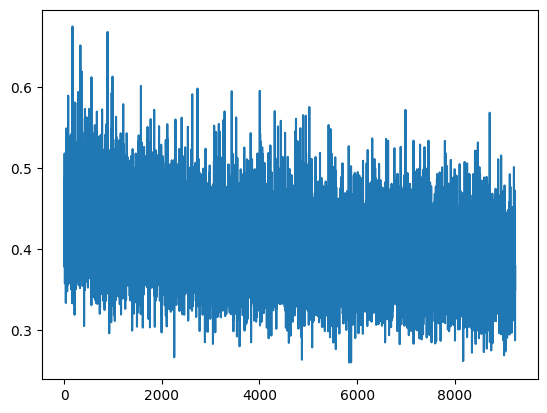

In [97]:
plt.plot(loss_history)

In [39]:
model_paths = glob.glob("./jupyter_walkthrough/side_exp/energy_delta/*.pth")
model_list = []
for model_path in model_paths:
    # Define your model here, e.g., model = YourModelClass()
    model = MLP_edelta()
    model.load_state_dict(torch.load(model_path))
    model_list.append(model)
num_models = len(model_list)
print(f"Averaging {num_models} models.")
averaged_state_dict = None

for model in model_list:
    if averaged_state_dict is None:
        averaged_state_dict = model.state_dict()
    else:
        for key, value in model.state_dict().items():
            averaged_state_dict[key] += value
for key in averaged_state_dict.keys():
    averaged_state_dict[key] /= num_models

averaged_model = MLP_edelta()
averaged_model.load_state_dict(averaged_state_dict)

Averaging 4 models.


<All keys matched successfully>

In [40]:
_ = evaluate(model=averaged_model, val_loader=val_dataloader_edelta, device=device, naive_rmse=naive_rmse_mean, model_type=MODEL_TYPE)

val rmse mean: 0.7279636263847351. val rmse std: 0.6472634673118591. 
Model saved.


In [123]:
train_dataset_e = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_train.csv', 
    target_col='avg_energy'
)

In [124]:
train_dataloader_e = DataLoader(train_dataset_e, batch_size=256, shuffle=True)

In [125]:
val_dataset_e = ReversePredictionDataset(
    df_path='./jupyter_walkthrough/side_exp/video_to_prosody_v6_val.csv', 
    target_col='avg_energy'
)

In [126]:
val_dataloader_e = DataLoader(val_dataset_e, batch_size=64, shuffle=True)

In [164]:
model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
model = model.to(device)
criterion = criterion.to(device)

In [165]:
_ = naive_evaluate(model=model, train_loader=train_dataloader_e, val_loader=val_dataloader_e, device=device)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

NAIVE => val mse mean: 0.42482367157936096. val mse std: 0.6387670040130615. 


In [166]:
EPOCHS = 20

In [167]:
loss_history = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    model.train()
    for idx, data in tqdm(enumerate(train_dataloader_e)):
        # get the inputs; data is a list of [inputs, labels]
        X_train, y_train, infos = data
        (uid, vid, embedding_video_start_time, embedding_seq_nohistory_idx, pitch_mean, pitch_std, energy_mean, energy_std) = infos
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        pred_train = model(X_train)
        loss = criterion(pred_train.reshape(-1), y_train)
        loss.backward()
        optimizer.step()
        
        # print statistics
        loss_history.append(loss.detach().cpu().item())
    _ = evaluate(model=model, val_loader=val_dataloader_e, device=device)
    model.train()
    


print('Finished Training')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.4489368796348572. val mse std: 0.6518158316612244. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.44435369968414307. val mse std: 0.6676107048988342. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.4389379024505615. val mse std: 0.6752519607543945. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.4552084505558014. val mse std: 0.6604539155960083. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.45980167388916016. val mse std: 0.6711544990539551. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.47603562474250793. val mse std: 0.668940544128418. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.4670623540878296. val mse std: 0.67671138048172. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.4679466187953949. val mse std: 0.6759553551673889. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.4750944972038269. val mse std: 0.6940370798110962. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.47716036438941956. val mse std: 0.6866118907928467. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.5016497373580933. val mse std: 0.6981284022331238. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.4903665781021118. val mse std: 0.712966799736023. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.49875321984291077. val mse std: 0.7045289874076843. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.47898656129837036. val mse std: 0.7163333296775818. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.5065500736236572. val mse std: 0.7128041386604309. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.509129524230957. val mse std: 0.7187182903289795. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.4786791205406189. val mse std: 0.7285407781600952. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.49607405066490173. val mse std: 0.7165980935096741. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.49464523792266846. val mse std: 0.7280003428459167. 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

val mse mean: 0.491242378950119. val mse std: 0.7240238189697266. 
Finished Training


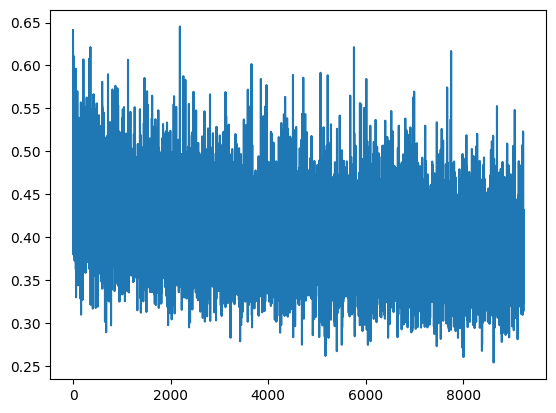

In [169]:
plt.plot(loss_history)